
⚠️ Warning: Some categorical columns are missing, skipping one-hot encoding.

✅ Final Processed Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   Partner                                7043 non-null   int64  
 2   Dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   PhoneService                           7043 non-null   int64  
 5   MultipleLines                          7043 non-null   float64
 6   OnlineSecurity                         7043 non-null   int64  
 7   OnlineBackup                           7043 non-null   int64  
 8   DeviceProtection                       7043 non-null   int64  
 9   TechSupport              

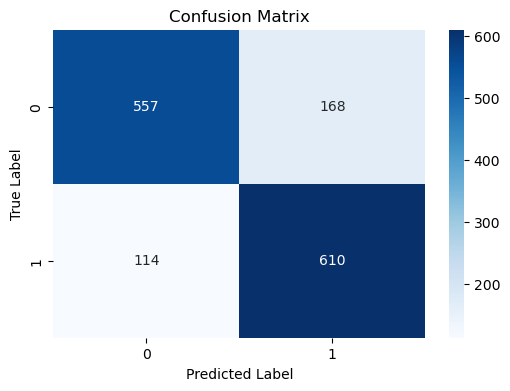


✅ Optimized XGBoost Model saved successfully!


<Figure size 1000x600 with 0 Axes>

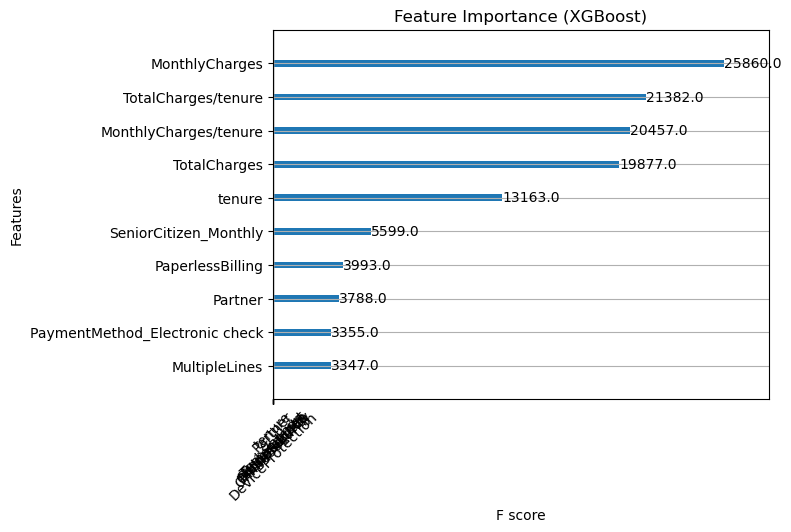

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 1️⃣ Load Cleaned Dataset
df = pd.read_csv("../backend/data/cleaned_telco_churn.csv")

# ✅ Ensure 'Churn' exists before proceeding
if "Churn" not in df.columns:
    raise ValueError("❌ 'Churn' column is missing from the dataset.")

# 2️⃣ Feature Engineering 🔥

# Fix missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Fills NaNs with median

# Prevent division by zero (replace tenure=0 with 1)
df["tenure"].replace(0, 1, inplace=True)

# **🚀 NEW: Create More Interaction Features**
df["TotalCharges/tenure"] = df["TotalCharges"] / (df["tenure"] + 1)
df["MonthlyCharges/tenure"] = df["MonthlyCharges"] / (df["tenure"] + 1)
df["SeniorCitizen_Monthly"] = df["SeniorCitizen"] * df["MonthlyCharges"]

# **🚀 NEW: Bin 'tenure' into categories**
df["tenure_group"] = pd.cut(
    df["tenure"], bins=[0, 12, 24, 48, 72, 100], labels=[1, 2, 3, 4, 5]
).astype("int64")

# **Fix One-Hot Encoding Issue (Check columns exist before encoding)**
categorical_columns = ["InternetService", "Contract", "PaymentMethod"]
existing_categoricals = [col for col in categorical_columns if col in df.columns]

if existing_categoricals:
    df = pd.get_dummies(df, columns=existing_categoricals, drop_first=True)
else:
    print("\n⚠️ Warning: Some categorical columns are missing, skipping one-hot encoding.")

# **🚀 Drop Less Important Features** (Based on Feature Importance)
df.drop(columns=["gender", "StreamingTV", "StreamingMovies"], inplace=True)

# ✅ Print dataset info after modifications
print("\n✅ Final Processed Dataset Overview:")
print(df.info())

# 3️⃣ Check for NaN values before proceeding
print("\n❗ Checking for NaN values in dataset:")
print(df.isnull().sum().sum(), "NaN values found")  # Should print "0 NaN values found"

# Drop rows with NaN (As a last safety check)
df.dropna(inplace=True)

# 4️⃣ Split Data into Features (X) & Target (y)
X = df.drop(columns=["Churn"])
y = df["Churn"]

# 5️⃣ Handle Class Imbalance using SMOTE (Oversampling Only)
smote = SMOTE(sampling_strategy=0.7, random_state=42)  # Adjusting ratio to prevent errors
X_resampled, y_resampled = smote.fit_resample(X, y)

# **Fix: UnderSample Carefully to Maintain Balance**
undersample = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)

# 6️⃣ Split into Train & Test Data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"✅ Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

# 7️⃣ Train a Default XGBoost Model Before Hyperparameter Tuning 🚀
baseline_model = XGBClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

# ✅ Check Baseline Model Accuracy Before Tuning
y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = round(accuracy_score(y_test, y_pred_baseline) * 100, 2)

# 🔹 Add a clear separator to ensure visibility
print("\n" + "=" * 50)  # Creates a visual separator in the console
print(f"✅ Baseline Model Accuracy: {baseline_accuracy} %")
print("=" * 50 + "\n")  # Closing separator

# 8️⃣ Hyperparameter Tuning with RandomizedSearchCV 🚀
params = {
    "n_estimators": [700, 1000, 1500],  
    "learning_rate": [0.01, 0.05, 0.1],  
    "max_depth": [7, 10, 12],  
    "min_child_weight": [1, 3, 5],  
    "gamma": [0.1, 0.2, 0.3],  
    "subsample": [0.85, 0.9],  
    "colsample_bytree": [0.8, 0.9],  
    "scale_pos_weight": [2, 3, 5]  # Increase weight for churners  
}

xgb_model = XGBClassifier(random_state=42)

grid = RandomizedSearchCV(xgb_model, params, cv=3, scoring="accuracy", verbose=1, n_jobs=-1, n_iter=20)
grid.fit(X_train, y_train)

# ✅ Best Model Found
best_model = grid.best_estimator_
print(f"\n✅ Best Parameters: {grid.best_params_}")

# 9️⃣ Evaluate Model Performance
y_pred = best_model.predict(X_test)
final_accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

# 🔹 Add a clear separator for visibility
print("\n" + "=" * 50)  # Creates a visible divider in the console
print(f"✅ Final Optimized Model Accuracy: {final_accuracy} %")
print("=" * 50 + "\n")  # Closing separator

# 🔹 Print Classification Report AFTER Accuracy (So it doesn’t get lost)
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))
# 🔟 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 1️⃣1️⃣ Save the Trained Model
joblib.dump(best_model, "../backend/models/churn_xgb_optimized.pkl")
print("\n✅ Optimized XGBoost Model saved successfully!")

# 1️⃣2️⃣ Plot Feature Importance (Fixed Labels)
plt.figure(figsize=(10, 6))
feature_names = X.columns  # Ensure correct feature names
xgb.plot_importance(best_model, importance_type="weight", max_num_features=10)
plt.xticks(ticks=np.arange(10), labels=feature_names[:10], rotation=45)  # Fix labels
plt.title("Feature Importance (XGBoost)")
plt.show()